# Dataset Link

https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset



<!-- https://www.kaggle.com/leoyuguanall/covid-19-chest-x-ray-classification -->

# VGG16

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


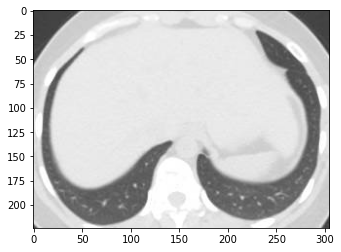

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


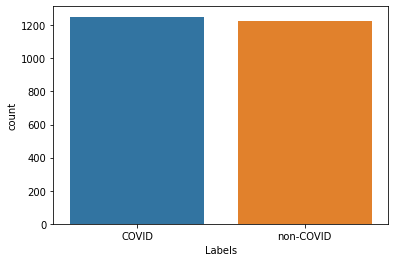

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def VGG16_model():
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(VGG16_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 25088)             14714688  
_________________________________________________________________
dropout_4 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 27,593,218
Trainable params: 12,878,530
Non-trainable params: 14,714,688
_________________________________

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
58/58 [==============================] - 26s 434ms/step - loss: 0.6197 - accuracy: 0.6675 - val_loss: 0.3353 - val_accuracy: 0.8551
Epoch 2/50
58/58 [==============================] - 22s 371ms/step - loss: 0.4054 - accuracy: 0.8061 - val_loss: 0.2907 - val_accuracy: 0.8792
Epoch 3/50
58/58 [==============================] - 22s 373ms/step - loss: 0.2618 - accuracy: 0.8892 - val_loss: 0.1913 - val_accuracy: 0.9227
Epoch 4/50
58/58 [==============================] - 22s 377ms/step - loss: 0.2104 - accuracy: 0.9168 - val_loss: 0.1830 - val_accuracy: 0.9308
Epoch 5/50
58/58 [==============================] - 22s 378ms/step - loss: 0.1874 - accuracy: 0.9254 - val_loss: 0.1594 - val_accuracy: 0.9404
Epoch 6/50
58/58 [==============================] - 22s 384ms/step - loss: 0.1566 - accuracy: 0.9411 - val_loss: 0.1468 - val_accuracy: 0.9452
Epoch 7/50
58/58 [==============================] - 22s 385ms/step - loss: 0.1540 - accuracy: 0.9416 - val_loss: 0.1301 - val_accuracy: 0.9436

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


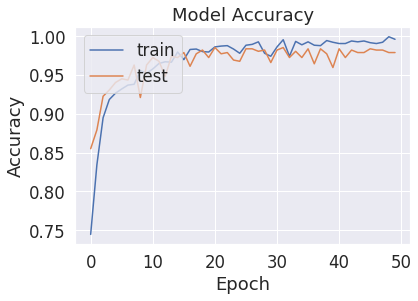

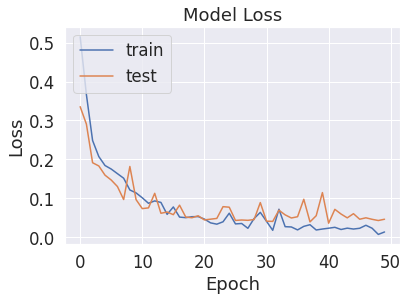

<Figure size 432x288 with 0 Axes>

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG16/vgg16_accuracy.jpg')


#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG16/vgg16_loss.jpg')

In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 3s 153ms/step - loss: 0.0461 - accuracy: 0.9791
Model accuracy on validation dataset: 97.906601.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[303  10]
 [  3 305]]


,COVID,non-COVID
COVID,303,10
non-COVID,3,305


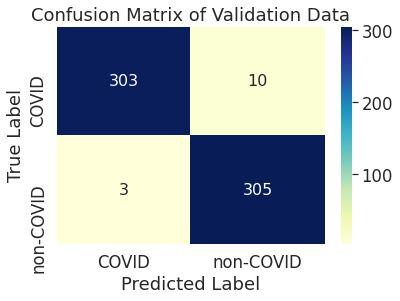

<Figure size 432x288 with 0 Axes>

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()
plt.savefig('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG16/Confusionmatrix.png')

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG16/vgg16_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG16/vgg16_weights_ct.hdf5')

# VGG19

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


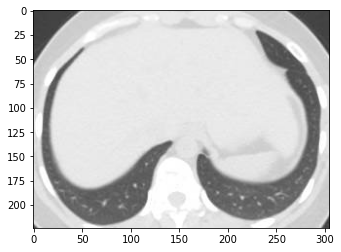

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


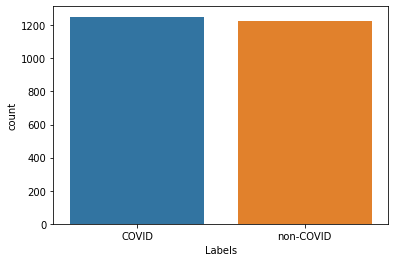

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def VGG19_model():
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(VGG19_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 25088)             20024384  
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 32,902,914
Trainable params: 12,878,530
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 35s 465ms/step - loss: 0.7671 - accuracy: 0.5403 - val_loss: 0.4392 - val_accuracy: 0.7874
Epoch 2/20
58/58 [==============================] - 23s 403ms/step - loss: 0.4137 - accuracy: 0.8191 - val_loss: 0.5844 - val_accuracy: 0.6876
Epoch 3/20
58/58 [==============================] - 24s 408ms/step - loss: 0.3992 - accuracy: 0.8150 - val_loss: 0.3066 - val_accuracy: 0.8728
Epoch 4/20
58/58 [==============================] - 24s 410ms/step - loss: 0.3463 - accuracy: 0.8495 - val_loss: 0.2568 - val_accuracy: 0.9050
Epoch 5/20
58/58 [==============================] - 24s 406ms/step - loss: 0.2551 - accuracy: 0.9082 - val_loss: 0.2241 - val_accuracy: 0.9211
Epoch 6/20
58/58 [==============================] - 24s 408ms/step - loss: 0.2470 - accuracy: 0.8922 - val_loss: 0.2192 - val_accuracy: 0.9130
Epoch 7/20
58/58 [==============================] - 24s 405ms/step - loss: 0.1980 - accuracy: 0.9304 - val_loss: 0.1892 - val_accuracy: 0.9195

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


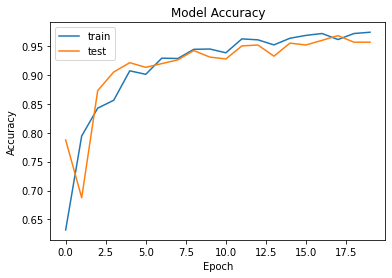

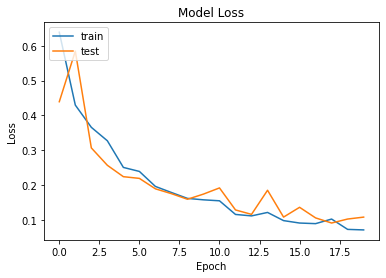

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 4s 198ms/step - loss: 0.1080 - accuracy: 0.9565
Model accuracy on validation dataset: 95.652175.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 0
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1
 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 0 0 0 1 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[306   7]
 [ 20 288]]


,COVID,non-COVID
COVID,306,7
non-COVID,20,288


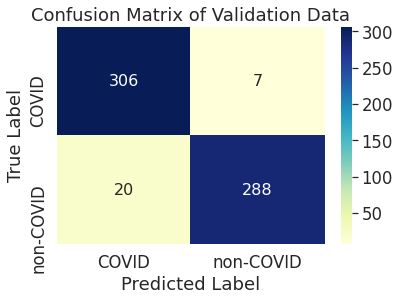

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG19/vgg19_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/VGG19/vgg19_weights_ct.hdf5')

# Xception

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


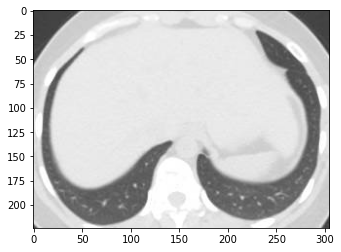

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


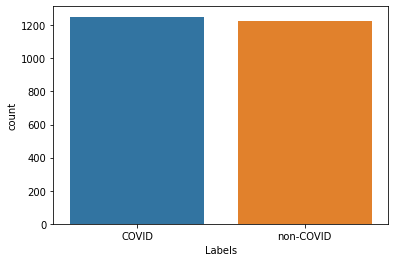

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def Xception_model():
    base_model = Xception(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(Xception_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            20861480  
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 72,275,178
Trainable params: 51,413,698
Non

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 34s 433ms/step - loss: 0.8511 - accuracy: 0.6595 - val_loss: 0.3901 - val_accuracy: 0.8454
Epoch 2/20
58/58 [==============================] - 23s 397ms/step - loss: 0.4374 - accuracy: 0.8146 - val_loss: 0.4640 - val_accuracy: 0.8164
Epoch 3/20
58/58 [==============================] - 23s 403ms/step - loss: 0.3255 - accuracy: 0.8628 - val_loss: 0.2575 - val_accuracy: 0.8969
Epoch 4/20
58/58 [==============================] - 23s 403ms/step - loss: 0.2698 - accuracy: 0.8908 - val_loss: 0.3862 - val_accuracy: 0.8068
Epoch 5/20
58/58 [==============================] - 23s 401ms/step - loss: 0.2634 - accuracy: 0.8767 - val_loss: 0.2201 - val_accuracy: 0.9114
Epoch 6/20
58/58 [==============================] - 23s 400ms/step - loss: 0.2072 - accuracy: 0.9129 - val_loss: 0.2160 - val_accuracy: 0.8986
Epoch 7/20
58/58 [==============================] - 23s 404ms/step - loss: 0.1649 - accuracy: 0.9331 - val_loss: 0.2962 - val_accuracy: 0.8776

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


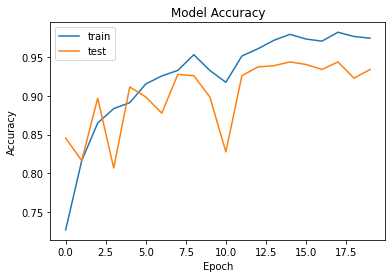

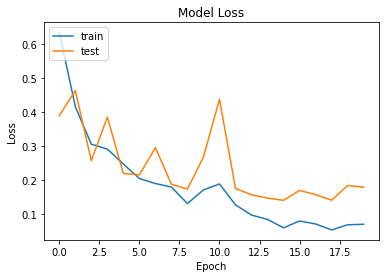

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 4s 179ms/step - loss: 0.1797 - accuracy: 0.9340
Model accuracy on validation dataset: 93.397748.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1 1 0 0 1
 1 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0
 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 1
 0 0 1 0 0 0 1 0 0 1 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[276  37]
 [  4 304]]


,COVID,non-COVID
COVID,276,37
non-COVID,4,304


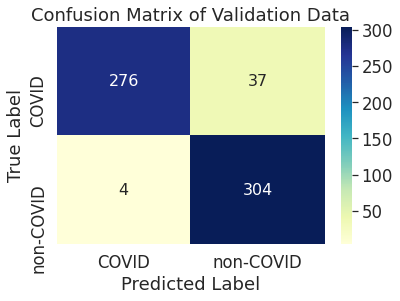

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/Xception/Xception_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/Xception/Xception_weights_ct.hdf5')

# Resnet50

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


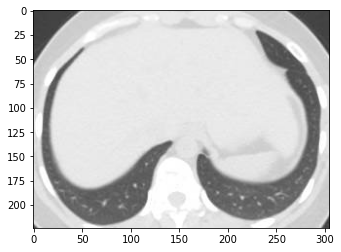

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


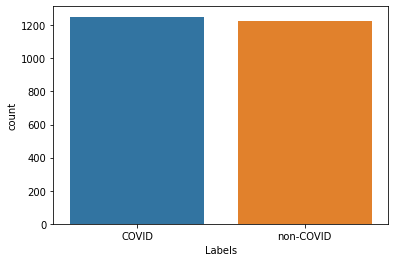

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def ResNet50_model():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(ResNet50_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23587712  
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 75,001,410
Trainable params: 51,413,698
Non-trainable params: 23,587,712
___________________________________

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 33s 397ms/step - loss: 1.0129 - accuracy: 0.5006 - val_loss: 0.6331 - val_accuracy: 0.6490
Epoch 2/20
58/58 [==============================] - 21s 357ms/step - loss: 0.6958 - accuracy: 0.5780 - val_loss: 0.6331 - val_accuracy: 0.6506
Epoch 3/20
58/58 [==============================] - 21s 357ms/step - loss: 0.6783 - accuracy: 0.6034 - val_loss: 0.6010 - val_accuracy: 0.6860
Epoch 4/20
58/58 [==============================] - 21s 358ms/step - loss: 0.6276 - accuracy: 0.6366 - val_loss: 0.5844 - val_accuracy: 0.6989
Epoch 5/20
58/58 [==============================] - 21s 359ms/step - loss: 0.6224 - accuracy: 0.6559 - val_loss: 0.5346 - val_accuracy: 0.7246
Epoch 6/20
58/58 [==============================] - 21s 362ms/step - loss: 0.5576 - accuracy: 0.7038 - val_loss: 0.5474 - val_accuracy: 0.7182
Epoch 7/20
58/58 [==============================] - 21s 362ms/step - loss: 0.5856 - accuracy: 0.6999 - val_loss: 0.5320 - val_accuracy: 0.7279

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


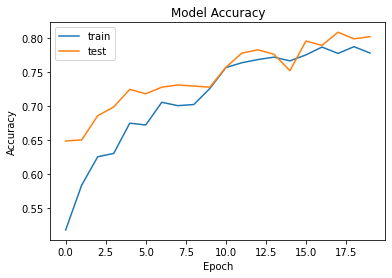

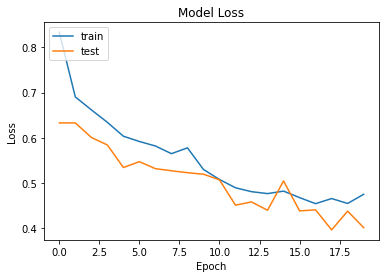

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 2s 114ms/step - loss: 0.4019 - accuracy: 0.8019
Model accuracy on validation dataset: 80.193239.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0
 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0
 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 0
 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 0 1
 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1
 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0
 0 0 1 0 0 1 0 1 0 1 0 1 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[253  60]
 [ 63 245]]


,COVID,non-COVID
COVID,253,60
non-COVID,63,245


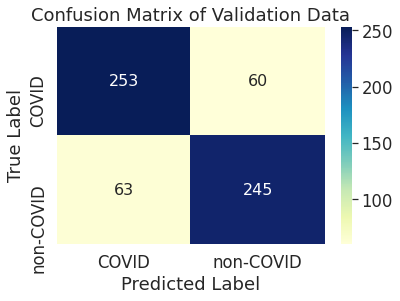

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/ResNet50/ResNet50_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/ResNet50/ResNet50_weights_ct.hdf5')

# Resnet50V2

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19, ResNet50V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


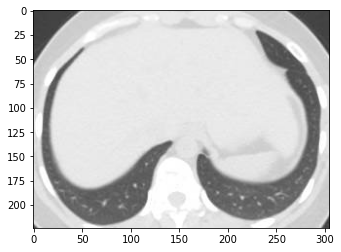

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


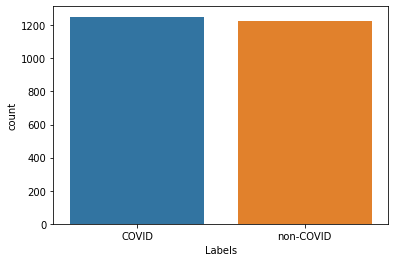

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def ResNet50V2_model():
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(ResNet50V2_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

94674944/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            23564800  
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 74,978,498
Trainable params: 51,413,698
Non

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 32s 392ms/step - loss: 1.1554 - accuracy: 0.6433 - val_loss: 0.3589 - val_accuracy: 0.8438
Epoch 2/20
58/58 [==============================] - 20s 350ms/step - loss: 0.3338 - accuracy: 0.8606 - val_loss: 0.3139 - val_accuracy: 0.8647
Epoch 3/20
58/58 [==============================] - 20s 347ms/step - loss: 0.2236 - accuracy: 0.9089 - val_loss: 0.3020 - val_accuracy: 0.8792
Epoch 4/20
58/58 [==============================] - 20s 347ms/step - loss: 0.1724 - accuracy: 0.9352 - val_loss: 0.2074 - val_accuracy: 0.9163
Epoch 5/20
58/58 [==============================] - 20s 347ms/step - loss: 0.1320 - accuracy: 0.9473 - val_loss: 0.1752 - val_accuracy: 0.9356
Epoch 6/20
58/58 [==============================] - 20s 346ms/step - loss: 0.1481 - accuracy: 0.9467 - val_loss: 0.2061 - val_accuracy: 0.9324
Epoch 7/20
58/58 [==============================] - 20s 344ms/step - loss: 0.1406 - accuracy: 0.9451 - val_loss: 0.1790 - val_accuracy: 0.9404

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


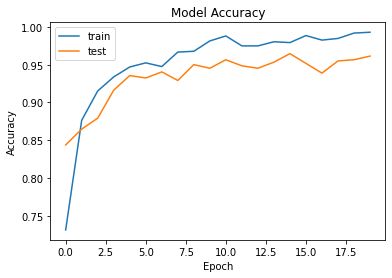

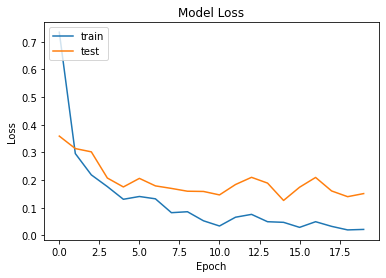

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 2s 103ms/step - loss: 0.1512 - accuracy: 0.9614
Model accuracy on validation dataset: 96.135265.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[298  15]
 [  9 299]]


,COVID,non-COVID
COVID,298,15
non-COVID,9,299


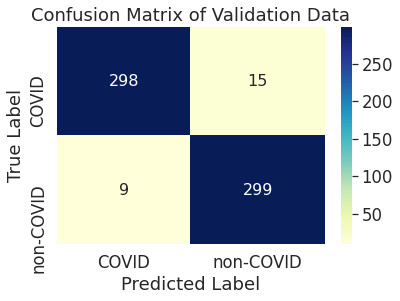

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/ResNet50V2/ResNet50V2_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/ResNet50V2/ResNet50V2_weights_ct.hdf5')

# DenseNet121

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19, DenseNet121
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


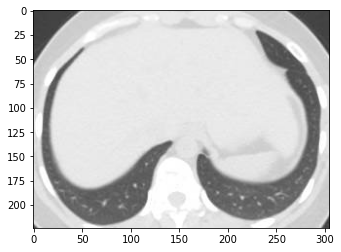

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


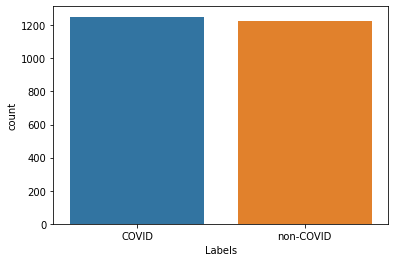

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def DenseNet121_model():
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(DenseNet121_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 50176)             7037504   
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 32,761,090
Trainable params: 25,723,586
Non

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 37s 416ms/step - loss: 1.4412 - accuracy: 0.5899 - val_loss: 0.3883 - val_accuracy: 0.8341
Epoch 2/20
58/58 [==============================] - 20s 348ms/step - loss: 0.4225 - accuracy: 0.8023 - val_loss: 0.3166 - val_accuracy: 0.8696
Epoch 3/20
58/58 [==============================] - 20s 346ms/step - loss: 0.2986 - accuracy: 0.8741 - val_loss: 0.2243 - val_accuracy: 0.9163
Epoch 4/20
58/58 [==============================] - 20s 346ms/step - loss: 0.2282 - accuracy: 0.9129 - val_loss: 0.1676 - val_accuracy: 0.9372
Epoch 5/20
58/58 [==============================] - 20s 345ms/step - loss: 0.2096 - accuracy: 0.9197 - val_loss: 0.1534 - val_accuracy: 0.9469
Epoch 6/20
58/58 [==============================] - 20s 349ms/step - loss: 0.1666 - accuracy: 0.9312 - val_loss: 0.1841 - val_accuracy: 0.9372
Epoch 7/20
58/58 [==============================] - 20s 345ms/step - loss: 0.1628 - accuracy: 0.9317 - val_loss: 0.1399 - val_accuracy: 0.9485

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


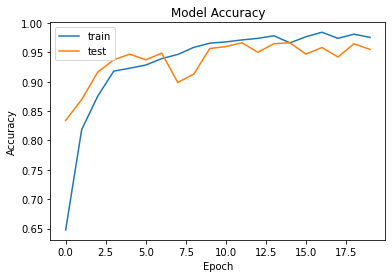

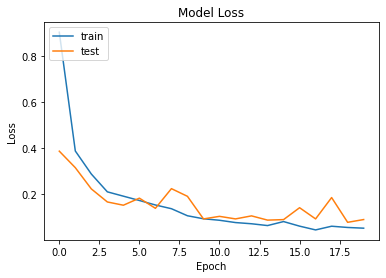

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 2s 121ms/step - loss: 0.0911 - accuracy: 0.9549
Model accuracy on validation dataset: 95.491141.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 1 0 0 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 0 0 0 1 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[307   6]
 [ 22 286]]


,COVID,non-COVID
COVID,307,6
non-COVID,22,286


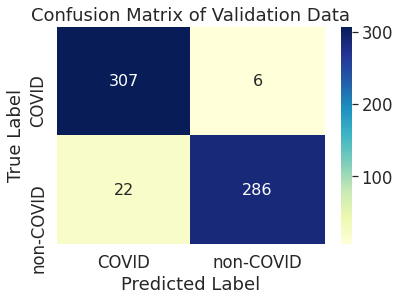

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/DenseNet121/DenseNet121_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/DenseNet121/DenseNet121_weights_ct.hdf5')

# ResNet101V2

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19, ResNet101V2
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


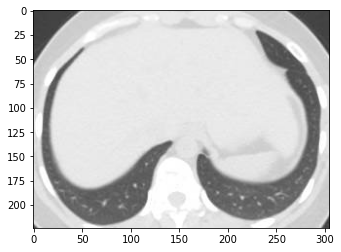

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


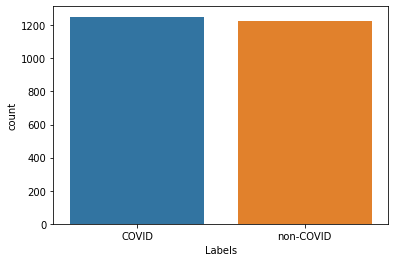

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def ResNet101V2_model():
    base_model = ResNet101V2(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(ResNet101V2_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

171319296/171317808 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 100352)            42626560  
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               51380736  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 94,040,258
Trainable params: 51,413,698
N

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 38s 453ms/step - loss: 0.8288 - accuracy: 0.7328 - val_loss: 0.4187 - val_accuracy: 0.8470
Epoch 2/20
58/58 [==============================] - 23s 395ms/step - loss: 0.3128 - accuracy: 0.8956 - val_loss: 0.2641 - val_accuracy: 0.9034
Epoch 3/20
58/58 [==============================] - 23s 396ms/step - loss: 0.2096 - accuracy: 0.9247 - val_loss: 0.2616 - val_accuracy: 0.9179
Epoch 4/20
58/58 [==============================] - 23s 398ms/step - loss: 0.1799 - accuracy: 0.9378 - val_loss: 0.1559 - val_accuracy: 0.9420
Epoch 5/20
58/58 [==============================] - 23s 399ms/step - loss: 0.1302 - accuracy: 0.9538 - val_loss: 0.2104 - val_accuracy: 0.9372
Epoch 6/20
58/58 [==============================] - 23s 403ms/step - loss: 0.0966 - accuracy: 0.9644 - val_loss: 0.1539 - val_accuracy: 0.9436
Epoch 7/20
58/58 [==============================] - 23s 401ms/step - loss: 0.0774 - accuracy: 0.9690 - val_loss: 0.1314 - val_accuracy: 0.9630

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


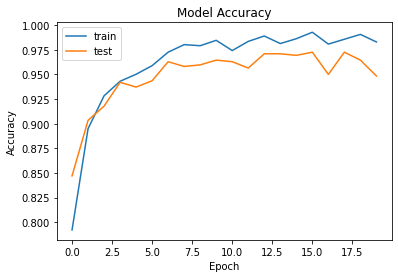

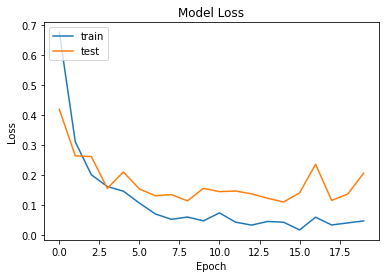

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 3s 172ms/step - loss: 0.2066 - accuracy: 0.9485
Model accuracy on validation dataset: 94.847023.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[305   8]
 [ 24 284]]


,COVID,non-COVID
COVID,305,8
non-COVID,24,284


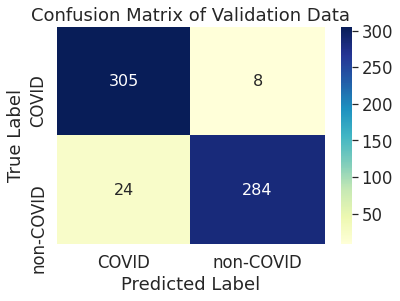

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/ResNet101V2/ResNet101V2_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/ResNet101V2/ResNet101V2_weights_ct.hdf5')

# Inception V3

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19, DenseNet169
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (585).png
(224, 305, 3)


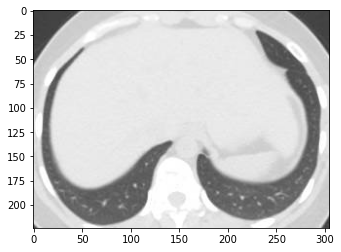

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


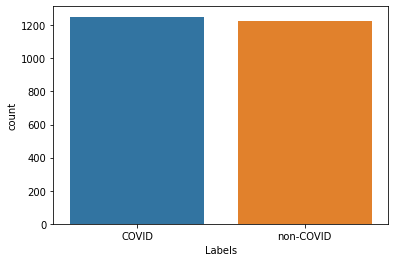

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16

def IneptionV3_model():
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(IneptionV3_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
58/58 [==============================] - 41s 456ms/step - loss: 1.4032 - accuracy: 0.6201 - val_loss: 0.3150 - val_accuracy: 0.8647
Epoch 2/20
58/58 [==============================] - 21s 366ms/step - loss: 0.3516 - accuracy: 0.8366 - val_loss: 0.2084 - val_accuracy: 0.9211
Epoch 3/20
58/58 [==============================] - 21s 365ms/step - loss: 0.2189 - accuracy: 0.9104 - val_loss: 0.1790 - val_accuracy: 0.9324
Epoch 4/20
58/58 [==============================] - 21s 364ms/step - loss: 0.2117 - accuracy: 0.9103 - val_loss: 0.2051 - val_accuracy: 0.9082
Epoch 5/20
58/58 [==============================] - 21s 365ms/step - loss: 0.1853 - accuracy: 0.9238 - val_loss: 0.1411 - val_accuracy: 0.9501
Epoch 6/20
58/58 [==============================] - 21s 362ms/step - loss: 0.1069 - accuracy: 0.9547 - val_loss: 0.1089 - val_accuracy: 0.9678
Epoch 7/20
58/58 [==============================] - 21s 364ms/step - loss: 0.1027 - accuracy: 0.9631 - val_loss: 0.1466 - val_accuracy: 0.9356

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


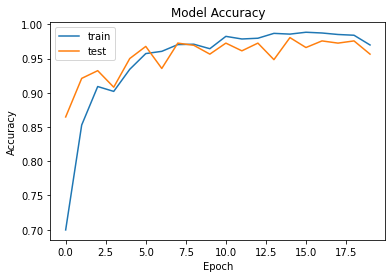

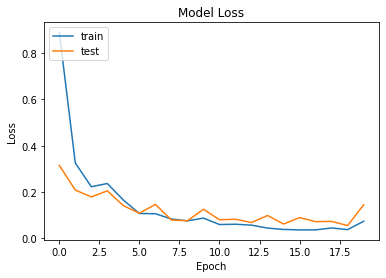

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 3s 153ms/step - loss: 0.1450 - accuracy: 0.9565
Model accuracy on validation dataset: 95.652175.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 0 0 0 1 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[310   3]
 [ 24 284]]


,COVID,non-COVID
COVID,310,3
non-COVID,24,284


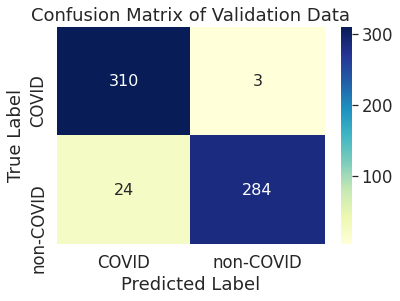

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/DenseNet169/DenseNet169_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/DenseNet169/DenseNet169_weights_ct.hdf5')

# Efficientnet B0

In [ ]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import np_utils

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet101, Xception, VGG19, DenseNet169
from tensorflow.keras.layers import Input, Dense, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, InputLayer

In [ ]:
LR = 0.0001
EPOCHS = 20
BATCH_SIZE = 32
IMG_SIZE = 224

In [ ]:
imagePaths = []

for dirname, _, filenames in os.walk('/content/drive/MyDrive/sarscov2-ctscan-dataset'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))


/content/drive/MyDrive/sarscov2-ctscan-dataset/COVID/Covid (174).png
(245, 380, 3)


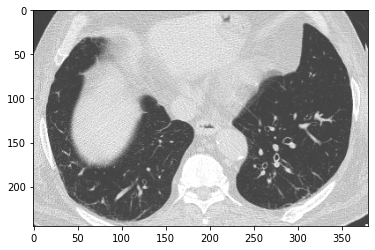

In [ ]:
print(imagePaths[66])

image = cv2.imread(imagePaths[0])
print(image.shape)

plt.imshow(image)
plt.show()

In [ ]:
X = []
y = []

for img_path in imagePaths:
    label = img_path.split(os.path.sep)[-2]
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
    
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(type(X), type(y), '\n')
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> 

(2481, 224, 224, 3) (2481,)


  Labels
0  COVID
1  COVID
2  COVID
3  COVID
4  COVID 

COVID        1252
non-COVID    1229
Name: Labels, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


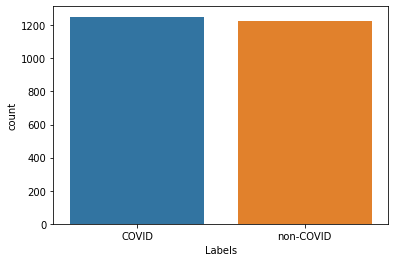

In [ ]:
#View counts of different labels
y_df = pd.DataFrame(y, columns=['Labels'])
print(y_df.head(), "\n")
print(y_df['Labels'].value_counts())

sns.countplot(y_df['Labels'])
plt.show()

In [ ]:
#Encode labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
#Convert list of labels to one-hot format
y_encoded = np_utils.to_categorical(y_encoded)

In [ ]:
#Check properties of label array
print(y_encoded, '\n')
print(y_encoded[0], '\n')
print(type(y_encoded), '\n')
print(le.classes_, '\n')

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]] 

[1. 0.] 

<class 'numpy.ndarray'> 

['COVID' 'non-COVID'] 



In [ ]:
#Generate training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=3)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

train_aug = ImageDataGenerator(rotation_range=15)

(1860, 224, 224, 3)
(1860, 2)
(621, 224, 224, 3)
(621, 2)


In [ ]:
#Transfer learning with VGG16
import tensorflow as tf


def efficientnet_model():
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
    
    output = base_model.layers[-1].output
    output = Flatten()(output)
    
    model = Model(base_model.input, outputs=output)
    
    for layer in model.layers:
        layer.trainable = False
    
    return model

In [ ]:
covid_model = Sequential()
covid_model.add(efficientnet_model()) #Change to ResNet or Xception as preferred
covid_model.add(Dropout(0.25))
covid_model.add(Dense(512, activation='relu'))
covid_model.add(Dropout(0.25))
covid_model.add(Dense(64, activation='relu'))
covid_model.add(Dense(2, activation='sigmoid'))

covid_model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 62720)             4049571   
_________________________________________________________________
dropout (Dropout)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               32113152  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 36,195,685
Trainable params: 32,146,114


In [ ]:
optim = Adam(lr = LR, decay = LR/EPOCHS)

covid_model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])

history = covid_model.fit_generator(train_aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                    steps_per_epoch=len(X_train)//BATCH_SIZE,
                                    validation_data=(X_test, y_test),
                                    validation_steps=len(X_test)//BATCH_SIZE,
                                    epochs=EPOCHS,
                                    verbose=1)

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


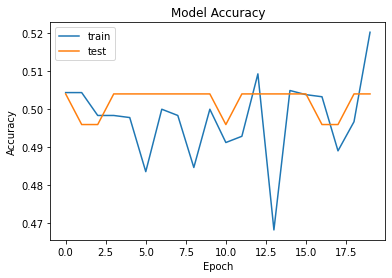

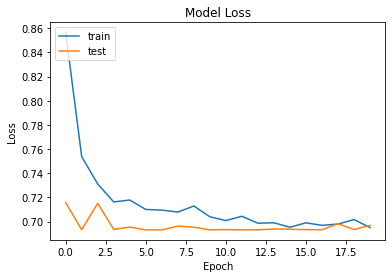

In [ ]:
#Accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



#Loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
score = covid_model.evaluate(X_test, y_test)
print("Model accuracy on validation dataset: %f." %(score[1]*100))

20/20 [==============================] - 3s 157ms/step - loss: 0.6968 - accuracy: 0.5040
Model accuracy on validation dataset: 50.402576.


In [ ]:
y_pred = np.argmax(covid_model.predict(X_test), axis=1)
print(y_pred)
print(len(y_pred))
print(le.classes_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [ ]:
y_test_labels = np.argmax(y_test, axis=1)
print(y_test_labels)
print(len(y_test_labels))

[1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1
 0 0 1 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1
 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1
 0 1 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1 0
 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1
 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1
 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 0 1 0 0 1 1 0 0 1 0 0 

In [ ]:
#Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
cm_df.head()

[[313   0]
 [308   0]]


,COVID,non-COVID
COVID,313,0
non-COVID,308,0


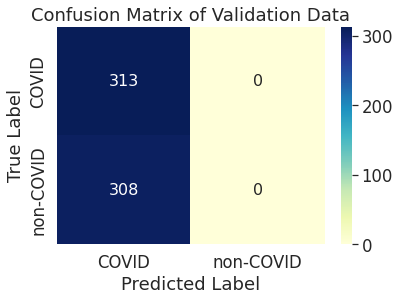

In [ ]:
sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(cm_df, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title('Confusion Matrix of Validation Data')
plt.show()

In [ ]:
covid_model.save('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/EfficientnetB0/EfficientnetB0_ct.h5')
covid_model.save_weights('/content/drive/MyDrive/Model and weights saved/SARS COV ll CT DS/EfficientnetB0/EfficientnetB0_weights_ct.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
